# **Evaluating a RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. Our toolkit includes [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

### **1. Import relevant packages**

In [1]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from getpass import getpass
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [2]:
load_dotenv()

True

### **2. Setup your openai key**

In [3]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### **3.  Retrieve the documents / dataset to be used**

In [4]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


### **4. Process dataset as langchain document for further processing**

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

  0%|          | 0/240 [00:00<?, ?it/s]

240

### **5. Test Evaluation Dataset Generation using Ragas**

In [6]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# generator with openai models
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(generator_llm , critic_llm , embeddings)

# generate testset
testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10, 
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

embedding nodes:   0%|          | 0/36 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

max retries exceeded for SimpleEvolution(generator_llm=LangchainLLMWrapper(run_config=RunConfig(timeout=60, max_retries=15, max_wait=90, max_workers=16, exception_types=<class 'openai.RateLimitError'>)), docstore=InMemoryDocumentStore(splitter=<langchain_text_splitters.base.TokenTextSplitter object at 0x152796140>, nodes=[Node(page_content="---\n\ndraft: false\n\ntitle: Food Discovery\n\nshort_description: Qdrant Food Discovery Demo recommends more similar meals based on how they look\n\ndescription: This demo uses data from Delivery Service. Users may like or dislike the photo of a dish, and the app will recommend more similar meals based on how they look. It's also possible to choose to view results from the restaurants within the delivery radius.\n\npreview_image: /demo/food-discovery-demo.png\n\nlink: https://food-discovery.qdrant.tech/\n\nweight: 2\n\nsitemapExclude: True\n\n---\n", metadata={'source': 'demo/demo-2.md'}, doc_id='35cf93bb-2cfb-4f11-9538-b5631e36c128', wins=2), Node

### **5a. Evaluation dataset to Pandas for better visualization**

In [7]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the purpose of a delimiter file in org...,[---\n\n#Delimiter files are used to separate ...,The purpose of a delimiter file in organizing ...,simple,[{'source': 'documentation/0-dl.md'}],True
1,How can Qdrant be used to develop a semantic s...,[---\n\ntitle: Examples\n\nweight: 25\n\n# If ...,You can use Qdrant to develop a semantic searc...,simple,[{'source': 'documentation/examples.md'}],True
2,What is the city associated with the keyphrase...,"[: ""city""\n\n value {\n\n string_value: ""B...","The city associated with the keyphrase ""Moscow...",simple,[{'source': 'documentation/quick-start.md'}],True
3,What is the status of the operation with opera...,[;\n\n\n\nvar operationInfo = await client.Ups...,Completed,simple,"[{'source': 'documentation/quick-start.md'}, {...",True
4,What is the role of a vector database in e-com...,[---\n\ndraft: false\n\ntitle: E-commerce prod...,This demo shows how you can use vector databas...,simple,[{'source': 'demo/demo-3.md'}],True
5,What does the Food Discovery demo do with dish...,[---\n\ndraft: false\n\ntitle: Food Discovery\...,The Food Discovery demo recommends more simila...,reasoning,[{'source': 'demo/demo-2.md'}],True
6,What is the purpose of using short description...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The purpose of using short descriptions of sta...,multi_context,"[{'source': 'demo/demo-1.md'}, {'source': 'dem...",True
7,Which Qdrant demo enables semantic search for ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,Startup Search,multi_context,[{'source': 'demo/demo-1.md'}],True
8,What is the Python toolset that supports migra...,[---\n\ntitle: Community links\n\nweight: 42\n...,The Python toolset that supports migration bet...,simple,[{'source': 'documentation/community-links.md'}],True


### **5b. Export the evaluation dataset to csv (if needed)**

In [9]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **6. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [10]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

### **7. Setting up Qdrant**

Set up the qdrant client and then create a collection so that our documents can be stored.

In [11]:

##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [12]:
## Collection name that will be used throughtout in the notebook
COLLECTION_NAME = "qdrant-docs-ragas"

In [13]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='qdrant-docs-ragas-haystack'), CollectionDescription(name='qdrant-docs-ragas-haystack-mxbai'), CollectionDescription(name='qdrant_docs_arize_dense'), CollectionDescription(name='qdrant_docs_arize_hybrid')])

In [14]:
## Declaring the intended Embedding Model with Fastembed
from fastembed.embedding import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

2024-04-29 15:52:37.213 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


,model,dim,description,size_in_GB,sources
0,BAAI/bge-base-en,768,Base English model,0.420,{'url': 'https://storage.googleapis.com/qdrant...
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.210,{'url': 'https://storage.googleapis.com/qdrant...
2,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'}
3,BAAI/bge-small-en,384,Fast English model,0.130,{'url': 'https://storage.googleapis.com/qdrant...
4,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'}
5,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.090,{'url': 'https://storage.googleapis.com/qdrant...
6,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.090,{'url': 'https://storage.googleapis.com/qdrant...
7,sentence-transformers/paraphrase-multilingual-...,384,"Sentence Transformer model, paraphrase-multili...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1'}
9,nomic-ai/nomic-embed-text-v1.5,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1.5'}


In [15]:
##Initilising embedding model
## Using Default Model - BAAI/bge-small-en-v1.5
#embedding_model = TextEmbedding()

## For custom model supported by Fastembed
#embedding_model = TextEmbedding(model_name="BAAI/bge-small-en", max_length=512)
embedding_model = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2", max_length=384)

embedding_model.model_name

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

'sentence-transformers/all-MiniLM-L6-v2'

### **8. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

In [16]:
docs_contents = []
docs_metadatas = []

for doc in docs_processed:
    if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
        docs_contents.append(doc.page_content)
        docs_metadatas.append(doc.metadata)
    else:
        # Handle the case where attributes are missing
        print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")

print("content : ",len(docs_contents))
print("metadata : ",len(docs_metadatas))

content :  4431
metadata :  4431


### **9. Adding document chunks into Qdrant Collection**

In [17]:
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

100%|██████████████████████████████████████████████████████████████████████████████████████| 77.7M/77.7M [00:19<00:00, 4.08MiB/s]


['ab2e436dc7a54f88a36decf9a767b205',
 '1c338ae0388845e281aadd127f62d827',
 '93e5d106eedd49bead2c7594966047f0',
 '143eeed777ac4f319008c60c0ba58cdd',
 '518f7d4f88c247298ff3feb4080f625d',
 'e2fb0f43a3af41038a6285046f8125e6',
 'ccf97ddfa98e43d4aa524e96144e4fc4',
 '921461da8a614c90bcae411ec407fa0b',
 '110b058859b54952b7a25e19f4601b39',
 'b17f85b8e75b479caa3e8f30a70906b9',
 '42ec6d70abaf4d158eb5b291c614801c',
 '550ef9a7adf642a4aca08b82ddcf957f',
 '71927d1fbd7641ccb2adc7e3375ebe54',
 '4fe7527f5f4645ed81411ca8cdcdb307',
 '1f10e9c5e5844dadba647d8e013472c2',
 '592cbf2996ef4fbbb54d2c4611fcac2f',
 '7da36de6c7764c8d95a5c785892542cd',
 '39140fc65d90450d832f4e09cf03bb35',
 '393cc799b25d49b0b626dee11311683e',
 'c5793ca6d2924d1897302a588245375a',
 '6fb10d5042bb4b82976741da3c6ef4ef',
 '4255d7cf11e44bbc98fed0916518f733',
 'fdc04a68d34e401ebfefe0ab3880c63a',
 '3bb21818fb8243f49c481df2f049b746',
 '4ccdcdbac8e24504b17b67ae61178e17',
 '81145214a1a24c6484bf4c592652387b',
 'f06920a51183488c8d367f0417c1ba5c',
 

In [18]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=4431)

### **10. Searching for the document**

In [19]:
## Searching for document chunks similar to query for context
search_result = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
for res in search_result:
    print("Id: ", res.id)
    print("Document : " , res.document)
    print("Score : " , res.score)
    print("Source : " , res.metadata['source'])

Id:  8b1d6591-1ab3-44d1-b50c-83c23aeb9b21
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced Performance and Efficiency with Binary Quantization
Score :  0.93278515
Source :  articles/binary-quantization-openai.md
Id:  d712ca08-cc4b-41f0-a592-7c0a06b8945c
Document :  Demetrios:

I see, okay, so basically this is the quantization. And now let's dive into the binary quantization and how it works.



Andrey Vasnetsov:
Score :  0.9211245
Source :  blog/binary-quantization-andrey-vasnetsov-vector-space-talk-001.md


### **11. Inititalize OpenAI**

In [20]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

### **12. Querying without the context**

In [21]:
def query_without_context(query):

    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".\n """
    )

    prompt_end = ( f"\n\nQuestion: {query}\nAnswer:" )

    prompt = ( prompt_start + "\n\n---\n\n" +  prompt_end )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return (res.choices[0].text)

In [22]:
print (query_without_context(query = "what is binary quantization?"))

 Binary quantization is a process of converting numerical data into binary form, where each value is represented by a sequence of 0s and 1s. This technique is commonly used in machine learning and data compression to reduce the size of data while maintaining its accuracy. You can learn more about binary quantization and its applications on page 12 of the "Data Compression" section in the documentation.


In [23]:
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 To reproduce the benchmark for Open Source vector databases, you can follow the steps outlined in the documentation on page 5 of the 'Benchmarking' section. This section provides detailed instructions on how to set up and run the benchmark, as well as how to interpret the results. Additionally, you can refer to the 'Benchmarking' section on page 4 for more information on the purpose and methodology of the benchmark. If you encounter any issues or have further questions, please refer to the 'Troubleshooting' section on page 6 or reach out to the community for assistance.


### **13. Querying with Context from Qdrant**

In [24]:
def query_with_context(query,limit):

    ## Fetch context from Qdrant
    search_result = client.query(collection_name=COLLECTION_NAME, query_text=query, limit=limit)

    contexts = [
        "document:"+r.document+",source:"+r.metadata['source'] for r in search_result
    ]
    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information 
        from the documentation.
        Remember to: 
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"), 
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".
        
        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (contexts , res.choices[0].text)

In [25]:
question1 = "what is quantization?"
RETRIEVAL_WINDOW_SIZE_5 = 5
context1 , rag_response1 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response1)

 Quantization is an optional feature in Qdrant that enables efficient storage and search of high-dimensional vectors. It compresses data while preserving relative distances between vectors, making vector search algorithms more efficient. This is achieved by converting traditional float32 vectors into qbit vectors and creating quantum entanglement between them. This unique phenomenon in quantum systems allows for highly efficient vector search algorithms. For more information on quantization methods and their mechanics, please refer to the documentation on quantization at https://qdrant.tech/documentation/guides/quantization.html.


In [26]:
RETRIEVAL_WINDOW_SIZE_3 = 3
context2 , rag_response2 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2)

 Quantization is a technique that uses quantum computing to improve the search process in artificial neural networks (ANNs). It involves converting traditional float32 vectors into qbit vectors and creating quantum entanglement between them. This allows for highly efficient vector search algorithms to be developed. This information can be found in the article "Quantum Quantization and Entanglement" in the 'articles' section of the documentation.


In [27]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. The benchmarks are fully open-sourced and contributions are welcome. This information can be found in the 'How to reproduce the benchmark?' section of the 'benchmarks/benchmark-faq.md' page.


In [28]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. This information can be found in the 'How to reproduce the benchmark?' section of the 'Benchmarking Vector Databases' document, which can be found in the 'benchmarks' folder of the 'benchmarks-intro.md' file.


### **14. Prepare the evaluation dataset to evaluate our RAG system**

In [29]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truths'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []
    
    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        answer = entry['answer']
        questions.append(question)
        ground_truths.append(answer)
        context , rag_response = query_with_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)
    
    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    
    return rag_response_data

In [30]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_3 = 3

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_3 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_3)

rag_eval_dataset_512_3

{'question': ['What is vaccum optimizer ?',
  'Tell me about ‘always_ram’ parameter?',
  'What is difference between scalar and product quantization?',
  'What is ‘best_score’ strategy?',
  'How does oversampling helps?',
  'What is the purpose of ‘CreatePayloadIndexAsync’?',
  'What is the purpose of ef_construct in HNSW ?',
  'How do you use ‘ordering’ parameter?',
  'What is significance of ‘on_disk_payload’ setting?',
  'What is the impact of ‘write_consistency_factor’ ?'],
 'answer': [" The vacuum optimizer is a feature that helps to optimize the performance of a collection by removing deleted documents and reclaiming disk space. This is done by setting a threshold for the number of deleted documents that can trigger the optimization process. This information can be found in the 'optimizer_config' section of the documentation on collections, specifically in the 'deleted_threshold' field.",
  ' The `always_ram` parameter determines whether quantized vectors are kept in RAM or not. 

In [31]:
rag_response_dataset_512_3 = Dataset.from_dict(rag_eval_dataset_512_3)
rag_response_dataset_512_3.to_csv('rag_response_512_3.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

24797

### **15. Lets evaluate , how good is our RAG !!**

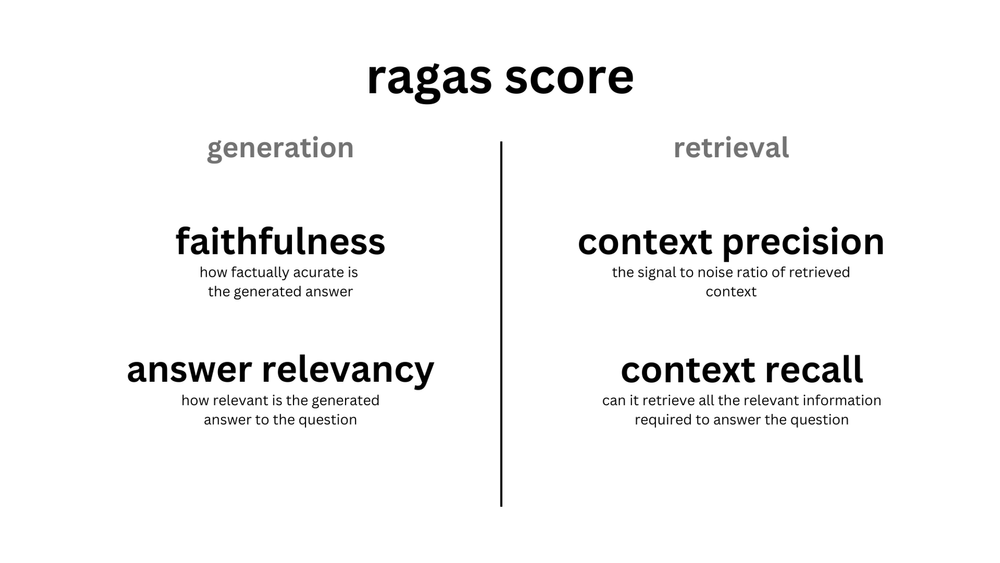

In [33]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_relevancy,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

In [42]:
## Method to encapsulate ragas evaluate method with all the 8 metrics
def evaluate_with_ragas(rag_response_dataset_df):
    result = evaluate(
        rag_response_dataset_df,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )
    return result

In [34]:
from ragas import evaluate
eval_dataset_512_3 = pd.read_csv('rag_response_512_3.csv')
eval_dataset_512_3.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter determines whether...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,The main difference between scalar and produc...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new approach i...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [37]:
result_512_3 = evaluate(
        rag_response_dataset_512_3,
        metrics=[
                faithfulness,
                answer_relevancy,
                context_recall,
                context_precision,
                context_relevancy,
                context_entity_recall,
                answer_similarity,
                answer_correctness
        ],
       raise_exceptions=False 
    )

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [38]:
evaluation_result_df_512_3 = result_512_3.to_pandas()
evaluation_result_df_512_3.iloc[:10]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,1.00,0.941121,1.000000,0.583333,0.058824,0.000000,0.901864,0.699156
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter determines whether...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,1.00,0.934677,0.666667,1.000000,0.095238,0.142857,0.935029,0.833757
2,What is difference between scalar and product ...,The main difference between scalar and produc...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,1.00,0.985974,1.000000,0.833333,0.133333,0.230769,0.912564,0.773595
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new approach i...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,1.00,0.988278,1.000000,1.000000,0.083333,0.000000,0.906777,0.688233
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.60,0.983618,0.666667,1.000000,0.100000,0.428571,0.842104,0.543837
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of 'CreatePayloadIndexAsync' is t...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,1.00,0.992021,1.000000,1.000000,0.048780,0.142857,0.909367,0.441628
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.00,0.955125,0.333333,1.000000,0.017857,0.125000,0.904146,0.654608
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,1.00,0.916255,1.000000,1.000000,0.013699,0.000000,0.804469,0.701117
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,1.00,0.860067,1.000000,1.000000,0.080000,0.250000,0.916632,0.416658
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0.75,0.942707,1.000000,1.000000,0.028571,0.538462,0.937476,0.609369


### **16. How to evaluate using the baseline evaluation dataset**

In [40]:

# loading the eval dataset from HF
qdrant_qa = load_dataset("atitaarora/qdrant_docs_qna_ragas")

#Converting contexts string to list of contexts for running further evals
qdrant_qa_eval = load_dataset("atitaarora/qdrant_docs_qna_ragas", split="train")
column_to_filter = "contexts"
# Filter rows with null values in the specified column
filtered_dataset = qdrant_qa_eval.filter(lambda example, column_name=column_to_filter: example[column_name] is not None)
#len(filtered_dataset)

filtered_dataset = filtered_dataset.map(lambda x: {"contexts":[x["contexts"]]})


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [41]:
from ragas import evaluate

result_baseline = evaluate(
    filtered_dataset,
    metrics=[
        answer_correctness,
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision
    ],
)


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

In [43]:
evaluation_result_df_baseline = result_baseline.to_pandas()
evaluation_result_df_baseline.head(20)

,question,ground_truth,answer,source,contexts,answer_correctness,answer_relevancy,faithfulness,context_recall,context_precision
0,What is the purpose of the locking feature in ...,The locking feature in Qdrant administration t...,The locking feature in Qdrant administration t...,documentation/guides/administration.md,[title: Administration\n\nweight: 10\n\naliase...,1.0,1.000000,1.000000,0.500000,1.0
1,What is the significance of the `on_disk_paylo...,The `on_disk_payload` setting in the storage c...,The `on_disk_payload` setting in the storage c...,documentation/guides/configuration.md,[storage:\n\n # Where to store all the data\n...,1.0,0.953128,1.000000,1.000000,1.0
2,What is the significance of the parameter `max...,The `max_segment_size_kb` parameter in the con...,The `max_segment_size_kb` parameter in the con...,documentation/guides/configuration.md,[default_segment_number: 0\n\n\n\n # Do not...,1.0,0.979010,1.000000,1.000000,1.0
3,What is the significance of the `indexing_thre...,The `indexing_threshold_kb` parameter specifie...,The `indexing_threshold_kb` parameter specifie...,documentation/guides/configuration.md,[memmap_threshold_kb: null\n\n\n\n # Maximu...,1.0,0.969266,1.000000,1.000000,1.0
4,How can you optimize Qdrant for minimizing lat...,To optimize Qdrant for minimizing latency in s...,To optimize Qdrant for minimizing latency in s...,documentation/guides/optimize.md,"[- `exact` - if set to `true`, will perform ex...",1.0,1.000000,1.000000,1.000000,1.0
5,How can Qdrant be configured to optimize throu...,To optimize throughput in Qdrant and utilize m...,To optimize throughput in Qdrant and utilize m...,documentation/guides/optimize.md,[.get();\n\n```\n\n\n\n```csharp\n\nusing Qdra...,1.0,0.924237,1.000000,1.000000,1.0
6,How can one enable distributed deployment mode...,To enable distributed deployment mode in Qdran...,To enable distributed deployment mode in Qdran...,documentation/guides/distributed_deployment.md,[---\n\ntitle: Distributed Deployment\n\nweigh...,1.0,1.000000,1.000000,1.000000,1.0
7,What is the recommended approach for determini...,"When creating a collection using Qdrant, it is...","When creating a collection using Qdrant, it is...",documentation/guides/distributed_deployment.md,[using Qdrant.Client.Grpc;\n\n\n\nvar client =...,1.0,0.967004,1.000000,1.000000,1.0
8,How is the discovery score computed in the con...,"In the context provided, the discovery score i...","In the context provided, the discovery score i...",documentation/concepts/explore.md,"[-1, &\quad s(v^+) < s(v^-)\n\n\end{cases}\n\n...",1.0,0.968043,1.000000,1.000000,1.0
9,How does Qdrant optimize storage at the segmen...,Qdrant optimizes storage at the segment level ...,Qdrant optimizes storage at the segment level ...,documentation/concepts/optimizer.md,[---\n\ntitle: Optimizer\n\nweight: 70\n\nalia...,1.0,1.000000,1.000000,1.000000,1.0


### **17. Improvision step by modifying the number of chunks retrieved to 4 and recreate the evaluation dataset**

In [39]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_4 = 4

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_4 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_4)

{'question': ['What is vaccum optimizer ?',
  'Tell me about ‘always_ram’ parameter?',
  'What is difference between scalar and product quantization?',
  'What is ‘best_score’ strategy?',
  'How does oversampling helps?',
  'What is the purpose of ‘CreatePayloadIndexAsync’?',
  'What is the purpose of ef_construct in HNSW ?',
  'How do you use ‘ordering’ parameter?',
  'What is significance of ‘on_disk_payload’ setting?',
  'What is the impact of ‘write_consistency_factor’ ?'],
 'answer': [' The vacuum optimizer is a feature that helps to optimize the performance of a collection by removing unused or deleted vectors. This is done by setting a threshold for the number of deleted vectors that can trigger the vacuum process. More information on the vacuum optimizer can be found in the documentation on collections, specifically in the section on optimizer configuration.',
  ' The `always_ram` parameter is used to determine whether to keep quantized vectors always cached in RAM or not. By d

In [40]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_4 = Dataset.from_dict(rag_eval_dataset_512_4)
## Saving the evaluation dataset offline 
rag_response_dataset_512_4.to_csv('rag_response_512_4.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

31780

In [43]:
eval_dataset_512_4 = pd.read_csv('rag_response_512_4.csv')
eval_dataset_512_4.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [44]:
result_512_4 = evaluate_with_ragas(rag_response_dataset_512_4)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [45]:
evaluation_result_df_512_4 = result_512_4.to_pandas()
evaluation_result_df_512_4.iloc[:10]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,1.000000,0.940303,1.000000,0.638889,0.025641,0.000000,0.905064,0.498996
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,1.000000,0.932524,0.666667,1.000000,0.047619,0.142857,0.946821,0.836705
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0.857143,0.930271,1.000000,0.805556,0.428571,0.230769,0.937634,0.567742
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,1.000000,0.988278,1.000000,1.000000,0.062500,1.000000,0.911055,0.727764
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.875000,0.983618,1.000000,1.000000,0.562500,0.428571,0.862799,0.677238
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,1.000000,0.934350,1.000000,1.000000,0.015873,0.142857,0.920901,0.775680
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.955148,0.333333,1.000000,0.013333,0.125000,0.918141,0.775006
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,1.000000,0.973410,1.000000,1.000000,0.011905,0.250000,0.783953,0.570988
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,0.800000,0.940829,1.000000,1.000000,0.066667,0.166667,0.894373,0.759308
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,1.000000,0.940565,1.000000,1.000000,0.041667,0.538462,0.926700,0.531675


### **18. Improvision step by modifying the number of chunks retrieved to 5 and recreate the evaluation dataset**

In [46]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_5 = 5

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_5 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_5)

In [47]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_5 = Dataset.from_dict(rag_eval_dataset_512_5)
## Saving the evaluation dataset offline 
rag_response_dataset_512_5.to_csv('rag_response_512_5.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

35236

In [48]:
from ragas import evaluate
eval_dataset_512_5 = pd.read_csv('rag_response_512_5.csv')
eval_dataset_512_5.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a component of the Mi...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The 'always_ram' parameter is a setting that ...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,The 'ordering' parameter is used to specify t...,['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [49]:
result_512_5 = evaluate_with_ragas(rag_response_dataset_512_5)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

In [50]:
evaluation_result_df_512_5 = result_512_5.to_pandas()
evaluation_result_df_512_5.iloc[:10]

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,context_relevancy,context_entity_recall,answer_similarity,answer_correctness
0,What is vaccum optimizer ?,The vacuum optimizer is a component of the Mi...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.800000,0.916066,1.000000,0.679167,0.019231,0.000000,0.873687,0.564562
1,Tell me about ‘always_ram’ parameter?,The 'always_ram' parameter is a setting that ...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,1.000000,0.929844,0.666667,1.000000,0.037500,0.142857,0.952574,0.783598
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0.800000,0.919842,1.000000,0.804167,0.192308,0.230769,0.936685,0.609169
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,1.000000,0.988278,1.000000,1.000000,0.051282,1.000000,0.909864,0.363830
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.833333,0.983618,0.333333,1.000000,0.428571,0.428571,0.879659,0.669915
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,1.000000,0.898982,0.333333,1.000000,0.011364,0.142857,0.909313,0.677328
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW is used to...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,1.000000,0.955125,0.333333,1.000000,0.012346,0.125000,0.924054,0.776468
7,How do you use ‘ordering’ parameter?,The 'ordering' parameter is used to specify t...,[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0.750000,0.935810,1.000000,0.700000,0.010309,0.250000,0.829177,0.635866
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,1.000000,0.924693,1.000000,1.000000,0.072727,0.166667,0.902741,0.675685
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,1.000000,0.939290,1.000000,1.000000,0.039216,0.538462,0.937618,0.609404


### **19. Compare results with the previous evaluation iteration**

In [54]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2 , df3):
    # Extract the specified columns from both dataframes
    headers = [ 'faithfulness',
                'answer_relevancy',
                'context_recall',
                'context_precision',
                'context_relevancy',
                'context_entity_recall',
                'answer_similarity',
                'answer_correctness'
                ]
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(20, 4))
    
    # Plot bar plots for each header
    for i, header in enumerate(headers):
        ax = axes[i]
        ax.bar(['RW_3','RW_4', 'RW_5'], [df1[header].mean(), df2[header].mean(), df3[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


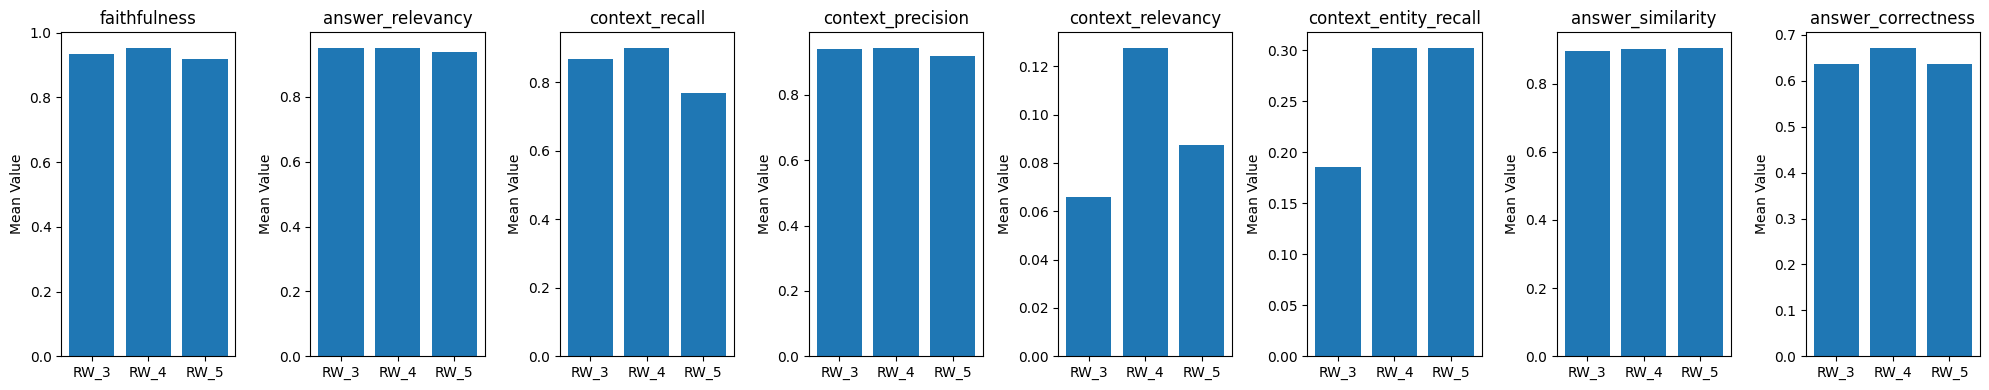

In [55]:
# Example result comparison:
compare_dataframes(evaluation_result_df_512_3, evaluation_result_df_512_4, evaluation_result_df_512_5)


### **20. Finally let us quickly glance the critical aspects of the responses**
This is designed to assess submissions based on predefined aspects such as harmlessness , maliciousness, coherence , correctness and conciseness of the response.

In [56]:
from datasets import Dataset 
from ragas.metrics.critique import harmfulness
from ragas.metrics.critique import maliciousness
from ragas.metrics.critique import coherence
from ragas.metrics.critique import correctness
from ragas.metrics.critique import conciseness
from ragas import evaluate

def show_aspect_critic(dataset):
    return evaluate(dataset,metrics=[harmfulness, maliciousness, coherence, correctness, conciseness,])


In [57]:
#show_aspect_critic(rag_response_dataset_512_3).to_pandas()
show_aspect_critic(rag_response_dataset_512_4).to_pandas()
#show_aspect_critic(rag_response_dataset_512_5).to_pandas()

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

,question,answer,contexts,ground_truth,harmfulness,maliciousness,coherence,correctness,conciseness
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0,0,1,1,1
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0,0,1,1,1
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0,0,1,1,1
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,0,0,1,1,1
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0,0,1,1,1
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0,0,1,1,1
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,0,0,1,1,1
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0,0,1,1,1
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,0,0,1,1,1
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0,0,1,1,1
